## Import the required libraries


In [1]:
import numpy as np   
import pandas as pd  
import math          
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

##  Defining the neural network class

I defined a neural network class with all the required functions inside it. There are a few functions like \_shapes, \_print_grads, etc. that helped me debug the code so I've kept them in this version too. 

In [2]:
class neural_net(object):
    
    def __init__(self, layer_dims=list(), learning_rate=0.002, optimizer="grad", mini_batch_size=32, epochs=20):
        self.epochs = epochs
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.mini_batch_size = mini_batch_size
        self.weights = [np.random.randn(l_1,l)*np.sqrt(2/l)+1e-7 for (l_1,l) in zip(layer_dims[1:], layer_dims[:-1])]
        self.biases = [np.random.randn(l,1)+1e-7 for l in layer_dims[1:]]
        self._Z = [np.zeros((l,mini_batch_size)) for l in layer_dims[1:]]
        self._activations = [np.zeros((l,mini_batch_size)) for l in layer_dims[1:]]
        self.dW = [np.zeros((weight.shape)) for weight in self.weights]
        self.db = [np.zeros((bias.shape)) for bias in self.biases]
        
    
    def softmax(self, z):
        a = np.divide(np.exp(z-np.max(z)), np.sum(np.exp(z-np.max(z))))
        return a
    

    def relu(self, Z):
        A = np.maximum(0,Z)
        return A


    def one_hot(self,y):
        encoded = np.zeros((len(np.unique(y)), y.shape[1]))
        for i,j in enumerate(y):
            encoded[j,i]=1
        return encoded
    
    
    def compute_cost(self, y, a_L):
        probs = y*(np.log(a_L+1e-6))
        cost = -np.divide(np.sum(probs), self.mini_batch_size)
        return cost
    
        
    def forward_prop(self, x):

        for l in range(len(self._Z)-1):
            self._Z[l] = np.dot(self.weights[l], x) + self.biases[l]
            self._activations[l] = self.relu(self._Z[l])
            x = self._activations[l]
        self._Z[-1] = np.dot(self.weights[-1], self._activations[-2]) + self.biases[-1]
        self._activations[-1] = self.softmax(self._Z[-1])
        return self._activations[-1]
    
    
    def backward_prop(self, x, y):
        dz = [np.zeros(z.shape) for z in self._Z]
        #dW = [np.zeros(weight.shape) for weight in self.weights]
        #db = [np.zeros(bias.shape) for bias in self.biases]
        dz[-1] = (self._activations[-1] - self.one_hot(y))
        self.dW[-1] = np.dot(dz[-1], self._activations[-2].T)
        self.db[-1] = np.sum(dz[-1])
        
        for i in range(2, len(self.layer_dims)):
            dz[-i] = np.dot(self.weights[-i+1].T, dz[-i+1])
            dz[-i]=dz[-i]*(self._Z[-i]>0)
            if i==len(self.layer_dims)-1:
                self.dW[-i] = np.dot(dz[-i], x.T)                
            else:
                self.dW[-i] = np.dot(dz[-i], self._activations[-i-1].T)
            self.db[-i] = np.sum(dz[-i])

    
    def update_params(self):    
        
        self.weights = [w - (self.learning_rate)*dweight for w,dweight in zip(self.weights, self.dW)]
        self.biases = [b - (self.learning_rate)*dbias for b,dbias in zip(self.biases, self.db)]
        

    def random_mini_batches(self, X, Y):
        mini_batch_size = self.mini_batch_size
        x,y = shuffle(X, Y, random_state=0)
        x = x.T           
        m = x.shape[1]  
        y = y.reshape(1,m)                      
        mini_batches = []
        num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
        
        for k in range(0, num_complete_minibatches):
        
            mini_batch_X = x[:,k * mini_batch_size:(k + 1) * mini_batch_size]
            mini_batch_Y = y[:,k * mini_batch_size:(k + 1) * mini_batch_size]
            
      
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
    
            end = m - mini_batch_size * math.floor(m / mini_batch_size)
            mini_batch_X = x[:,num_complete_minibatches * mini_batch_size:]
            mini_batch_Y = y[:,num_complete_minibatches * mini_batch_size:]
    
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        return mini_batches

    
    def fit(self, X, Y):
        mini_batches = self.random_mini_batches(X, Y)
        for i in range(self.epochs):
            print("Epoch ",i)
            for x,y in mini_batches:
                a_L = self.forward_prop(x)
                self.backward_prop(x, y)
                self.update_params()
                result = np.zeros(a_L.shape)
                result[np.argmax(a_L, axis=0)] = 1
                #if i%2==0:
                 #   print("Cost at epoch "+str(i)+':\t'+str(self.compute_cost(self.one_hot(y),self._activations[-1])))
                  #  print("Training accuracy:\t"+ str(np.mean(result==self.one_hot(y))))
            print("Accuracy in epoch ",i)
            self.evaluate(X,Y)
            
            
    def _shapes(self):
        for i in range(len(self._activations)):
            print("Activations:  ",self._activations[i].shape)
            print("Z:  " ,self._Z[i].shape)
            print("Weights:  ",self.weights[i].shape)
            print("biases:  ",self.biases[i].shape)
            
            
    def _print_params(self):
        for w,b in zip(self.weights, self.biases):
            print(w, b, sep='\t\t')
            
            
    def _print_activations(self):
        for a in self._activations:
            print(a)
    
    
    def _print_grads(self, print_shape=True):
        for i,j in zip(self.dW, self.db):
            print("dW:\t", i)
            if print_shape==True:
                print(i.shape)
            print("db:\t", j)
            if print_shape==True:
                print(j.shape)
    
    
    def evaluate(self, X, Y):
        mini_batches = self.random_mini_batches(X, Y)
        acc = []
        for x,y in mini_batches:
            proba = self.forward_prop(x)
            pred = np.zeros(proba.shape)
            pred[np.argmax(proba, axis=0)] = 1
            y = self.one_hot(y)
            acc.append(np.mean(pred==y))
        print(np.mean(acc))
        

## Loading the data

In [3]:
train = pd.read_csv("/home/aman/Work Stuff/fashionmnist/fashion-mnist_train.csv")
y = train["label"]
x = train.drop('label', axis=1)

## Visualizing few training examples

In [4]:
lst = []  
for i in range(0, 256,16):
    arr = np.reshape(x.iloc[i,:].values , newshape=(28,28))
    for j in range(i+1,i+16):
        arr = np.concatenate((arr, np.reshape(x.iloc[j,:].values, newshape=(28,28))), axis=0)
    lst.append(arr)
a = lst[0] 
for item in lst[1:]:
     a = np.concatenate((a, item), axis=1)
    
    

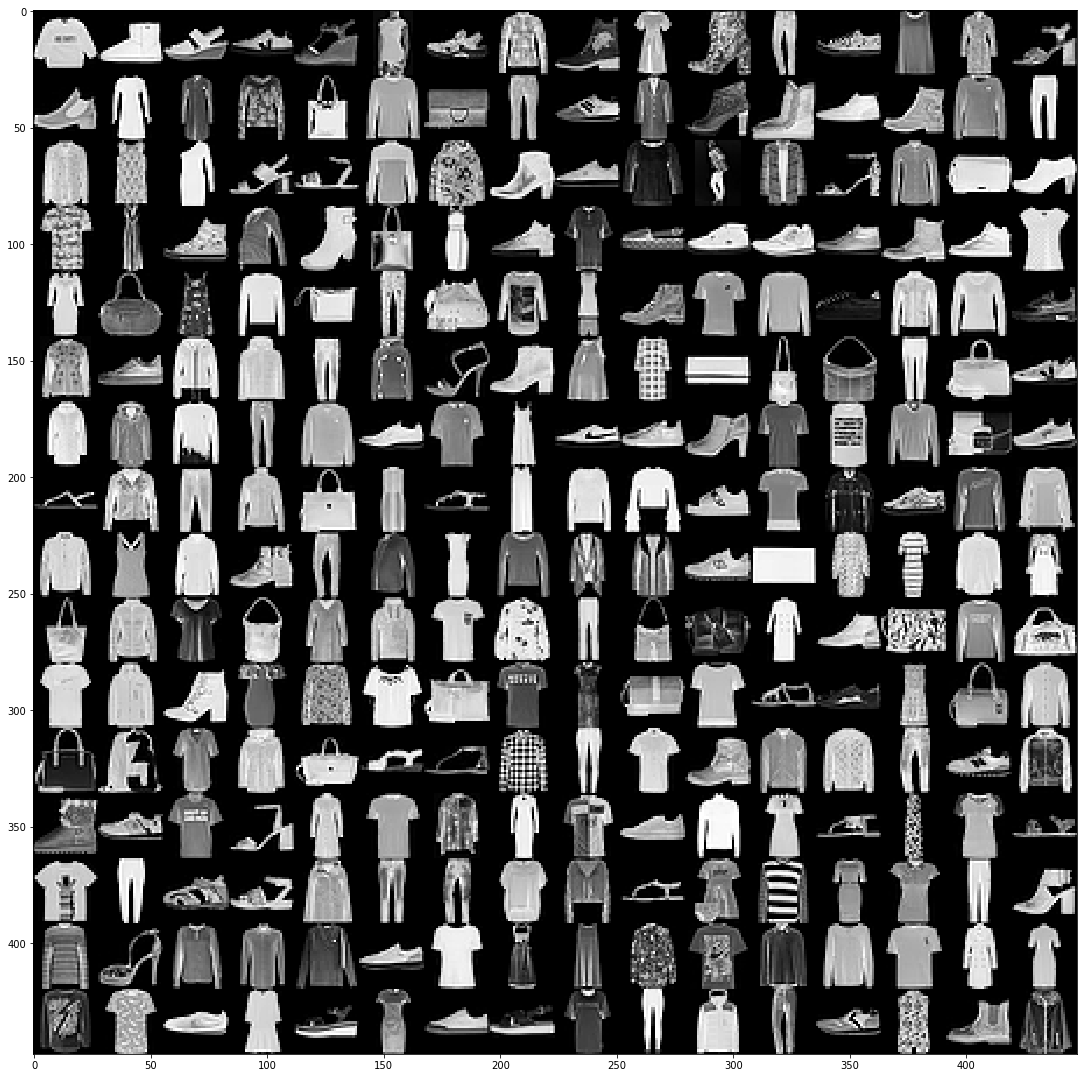

In [5]:
plt.figure(figsize=(6.4*4, 4.8*4))
plt.imshow(a, cmap=plt.cm.gray)

## Creating an object of the neural net class

In [6]:
nn = neural_net(layer_dims=[784,15,12,10], mini_batch_size=5000, learning_rate=0.0001, epochs=3)

## Training the model

In [7]:
nn.fit(x.values, y.values)

Epoch  0
Accuracy in epoch  0
0.79988
Epoch  1
Accuracy in epoch  1
0.8998399999999998
Epoch  2
Accuracy in epoch  2
0.8998399999999998


## Evaluating over test set:

In [8]:
test = pd.read_csv("/home/aman/Work Stuff/fashionmnist/fashion-mnist_test.csv")
y_test = test["label"]
x_test = test.drop('label', axis=1)

In [9]:
nn.evaluate(x_test.values, y_test.values)

0.89984
